# Convolutional neural network

## 1. Importing libraries

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 2. Loading the data

In [21]:
class DogsvsCats:

    IMG_SIZE = 50
    CATS = "../kagglecatsanddogs_5340/PetImages/Cat/"
    DOGS = "../kagglecatsanddogs_5340/PetImages/Dog/"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append(
                        [np.array(img), np.eye(2)[self.LABELS[label]]]
                    )
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)


REBUILD_DATA = False
if REBUILD_DATA:
    dogsvscats = DogsvsCats()
    dogsvscats.make_training_data()

training_data = np.load("training_data.npy", allow_pickle=True)

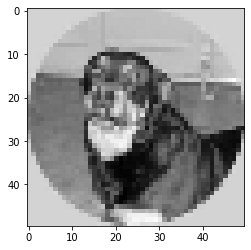

In [35]:
# Visualizing a sample
plt.imshow(training_data[6][0], cmap="gray")

## 3. Creating the NN class

In [64]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

### 3.1 Training

In [71]:
# Initializing the NN
net = Net()

# Optmizer and Loss function
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.0
y = torch.Tensor([i[1] for i in training_data])


# Creating the training and testing dataset
VAL_PCT = 0.1
val_size = int(len(X) * VAL_PCT)
train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]

# Training the NN
BATCH_SIZE = 100
EPOCHS = 3
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        batch_X = train_X[i : i + BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i : i + BATCH_SIZE]

        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|███████████████████████████████████████████████████| 225/225 [01:00<00:00,  3.69it/s]


Epoch: 0. Loss: 0.15891630947589874


100%|███████████████████████████████████████████████████| 225/225 [01:04<00:00,  3.50it/s]


Epoch: 1. Loss: 0.12610149383544922


100%|███████████████████████████████████████████████████| 225/225 [01:03<00:00,  3.54it/s]

Epoch: 2. Loss: 0.12014232575893402


### 3.2 Testing
- current accuracy is ~70% with 3 epochs of training

In [72]:
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(0, len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1

print("Accuracy: {}%".format(100 * np.around(correct / total, 3)))

100%|████████████████████████████████████████████████| 2494/2494 [00:04<00:00, 615.21it/s]

Accuracy: 70.1%
